<a href="https://colab.research.google.com/github/juansebastiancalderongarcia/Motor-control-for-speed-transition/blob/main/RNN_motor_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.optim import Adam
from torch import nn
import numpy as np
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

For all the speeds the dynamics is run over a total time of 2500. That is the reason why all the fast versions of the movement are set to zero in the remaining time

In [2]:
drive.mount('/mydrive')

Mounted at /mydrive


In [3]:
cd /mydrive/MyDrive/'Motor control'

/mydrive/MyDrive/Motor control


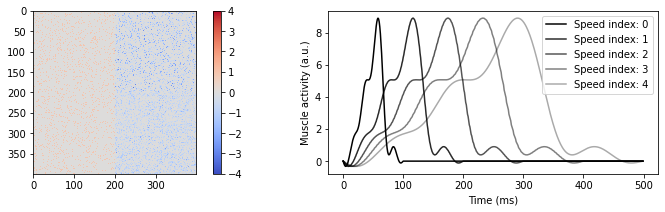

In [4]:
#Load the muscle activity
muscle_activity = np.load('./muscle_activity.npy')
#Load the Wsoc and the initial condition for the dynamics
with open('initial_dynamics.npy', 'rb') as f: 
    Wsoc = np.load(f)
    x0 = np.load(f)
#Plot the muscle activity
fig, (ax1,ax2) = plt.subplots(figsize = (13,3), ncols = 2)
pos = ax1.imshow(Wsoc, cmap = 'coolwarm', vmin=-4, vmax=4, interpolation = 'none')
fig.colorbar(pos, ax=ax1)
for i in range(muscle_activity.shape[1]):
  ax2.plot(muscle_activity[:,i], color = 'k', alpha = 1 - i/6, label = "Speed index: "+str(i))
ax2.set_xlabel('Time (ms)') 
ax2.legend()
ax2.set_ylabel('Muscle activity (a.u.)') 
fig.show()

# RNN

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$\tau \frac{dx}{dt} = -x + Wf(x,g)$$

$$x_{t+1} = x_{t} + \frac{1}{\tau}(-x_{t} + Wf(x_t,g))$$


$$z_t = m^T f(x_t,g) + b$$
<!-- $$ f(x,g) = \  $$ -->

In [5]:
muscle_activity_tensor = torch.tensor(muscle_activity, dtype=torch.float32).cuda()
print(muscle_activity_tensor.shape)

torch.Size([500, 5])


Create groups for gain modulation

In [ ]:
from random import sample

num_groups =  40 #Number of groups for group modulation
group_index = np.tile(np.arange(num_groups),round(400/num_groups))

if len(group_index) < 400:
    num_rest = N - round(N/num_groups)*num_groups #resting positions to group
    group_index = np.append(group_index, np.zeros((num_rest,)))
    group_index[-num_rest:] = sample(list(np.arange(num_groups)), num_rest)
    
group_index = sample(list(group_index), 400)

In [34]:

class RNNDynamics(nn.Module):
    def __init__(self, 
                 input_dim, # number of neurons * number of conditions
                 output_dim, # z dimension?
                 r_0 = 20,
                 r_max = 100,
                 tau = 200): 

        super(RNNDynamics, self).__init__()

        # create connectivity matrix with absolute random values
        self.W = torch.tensor(Wsoc, dtype=torch.float32).cuda()

        # creating g parameters
        # g = gain parameters for the slow version
        # g0 = gain parameters for the fast version constrained to be one

        self.g = nn.Parameter(torch.rand(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=True)
        # self.g_group = nn.Parameter(torch.rand(1,40, 
                                        #  dtype=torch.float32), 
                              # requires_grad=True)
        self.g0 = nn.Parameter(torch.ones(1,400, 
                                         dtype=torch.float32), 
                              requires_grad=False)
        
        self.h = 2500/500
        self.tau = tau
        self.r_0 = r_0
        self.r_max = r_max
        self.W_out = nn.Linear(400//2, 
                               1, 
                               bias=True) # `m` and `b` weights

    def f(self, x, g):
        mask = x < 0
        R = torch.empty_like(x).cuda() #[1,N]
        R[mask] = self.r_0
        R[~mask] = self.r_max-self.r_0

        return R * torch.tanh(x*g*(1./R)) #[1,N]

    def f_dynamics(self, x, g):
        F = torch.matmul(self.W, self.f(x,g).T).T
        return (1/self.tau)*(-x + F)
    
    def muscle_output(self,x,g):
        f_rate = self.f(x,g)
        mask = self.W.sum(0) > 0
        f_rate_exc = f_rate[mask.unsqueeze(0)].unsqueeze(0)
        return self.W_out(f_rate_exc)

    def RK4(self, x_initial, g, n_time):
        h = 5/n_time #delta time in RK4
        x_present = x_initial #[N,1]

        for time in range(1,n_time):
            k1 = self.f_dynamics(x_present, g)
            k2 = self.f_dynamics(x_present + (1/2)*k1, g)
            k3 = self.f_dynamics(x_present + (1/2)*k2, g)
            k4 = self.f_dynamics(x_present + k3, g)
        
            x_present = x_present + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        return x_present

    def forward(self,x_slow, x_fast):
        #Group modulation
        #for pos,val in enumerate(group_index):
        #    self.g[0,pos] = self.g_group[0,val]

        # W_out already includes m^T and b
        z_current_fast = self.muscle_output(x_fast, self.g0)
        z_current_slow = self.muscle_output(x_slow, self.g)

        x_new_fast = self.RK4(x_fast, self.g0, 5)
        x_new_slow = self.RK4(x_slow, self.g, 5)

        return z_current_slow, z_current_fast, x_new_slow, x_new_fast

In [45]:
N = 400
y_index = -1
n_epochs = 10
T,output_dim = muscle_activity_tensor.shape #[T,1]

rnn_dynamic = RNNDynamics(input_dim=2*N, # number of neurons * 2 conditions
                          output_dim=1*2, # z dimension * 2 conditions
                          r_0=20,
                          r_max=100).cuda()

#opt = Adam(rnn_dynamic.parameters(), lr = 1e-3, weight_decay = 1 )

opt = torch.optim.Adam(
[{'params': rnn_dynamic.W_out.parameters(), 'lr':1e-3, 'weight_decay':1}] +\
[{'params': rnn_dynamic.g, 'lr': 1e-3, 'weight_decay':0}]
)

x_slow_seqs = []
z_slow_seqs = []

x_fast_seqs = []
z_fast_seqs = []

losses = []
losses_slow = []
losses_fast = []

with torch.autograd.detect_anomaly():
  for ep in tqdm(range(n_epochs)):

    x_slow_seq = []
    z_slow_seq = []

    x_fast_seq = []
    z_fast_seq = []


    # Initial activity
    x_slow = torch.tensor(x0.T, dtype=torch.float32).cuda()
    x_fast = torch.tensor(x0.T, dtype=torch.float32).cuda()
    
    for t in range(T):
        x_slow_seq.append(x_slow) #When t = 0 it stores the initial condition
        x_fast_seq.append(x_fast) #When t = 0 it stores the initial condition

        z_current_slow, z_current_fast, x_slow, x_fast = rnn_dynamic(x_slow, x_fast)

        z_slow_seq.append(z_current_slow)
        z_fast_seq.append(z_current_fast)

    x_slow_seq = torch.cat(x_slow_seq, dim=0)
    x_fast_seq = torch.cat(x_fast_seq, dim=0)

    z_slow_seq = torch.cat(z_slow_seq, dim=0)
    z_fast_seq = torch.cat(z_fast_seq, dim=0)

    loss_slow = torch.pow(torch.norm(z_slow_seq.squeeze() - muscle_activity_tensor[:,-1]), 2)
    loss_fast = torch.pow(torch.norm(z_fast_seq.squeeze() - muscle_activity_tensor[:,0]), 2)
    loss = loss_slow + loss_fast
    
    opt.zero_grad()
    loss.backward() 
    opt.step()

    losses.append(loss.item())
    losses_slow.append(loss_slow.item())
    losses_fast.append(loss_fast.item())

    x_slow_seqs.append(x_slow_seq.detach().cpu().numpy())
    x_fast_seqs.append(x_fast_seq.detach().cpu().numpy())

    z_slow_seqs.append(z_slow_seq.detach().cpu().numpy())
    z_fast_seqs.append(z_fast_seq.detach().cpu().numpy())

x_slow_seqs = np.array(x_slow_seqs)
z_slow_seqs = np.array(z_slow_seqs)

x_fast_seqs = np.array(x_fast_seqs)
z_fast_seqs = np.array(z_fast_seqs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
100%|██████████| 10/10 [14:45<00:00, 88.58s/it]


(10, 500, 400)


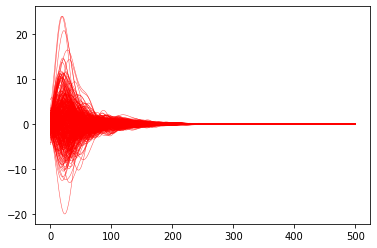

In [46]:
print(x_fast_seqs.shape)
plt.plot(x_fast_seqs[-1,:,:], color = 'red', alpha = 0.7, linewidth = 0.5)
plt.show()

(10, 500, 400)


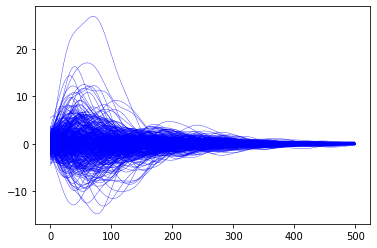

In [47]:
print(x_fast_seqs.shape)
plt.plot(x_slow_seqs[-1,:,:], color = 'blue', alpha = 0.7, linewidth = 0.5)
plt.show()

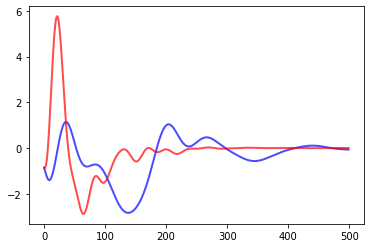

In [48]:
plt.plot(x_slow_seqs[-1,:,2], color = 'blue', alpha = 0.7, linewidth = 2)
plt.plot(x_fast_seqs[-1,:,2], color = 'red', alpha = 0.7, linewidth = 2)
plt.show()

9586.146484375


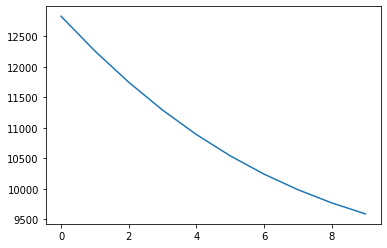

In [49]:
plt.plot(losses)
print(losses[-1])

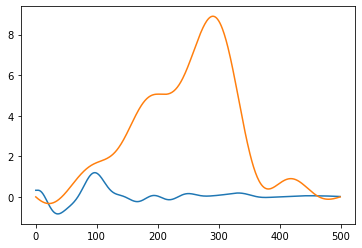

In [50]:
plt.plot(z_slow_seqs[-1])
plt.plot(muscle_activity_tensor[:,-1].detach().cpu().numpy())

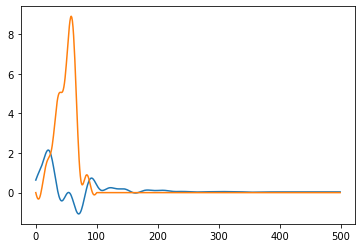

In [51]:
plt.plot(z_fast_seqs[-1])
plt.plot(muscle_activity_tensor[:,0].detach().cpu().numpy())


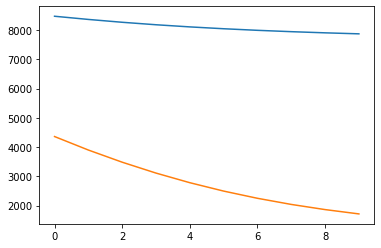

In [52]:
plt.plot(losses_slow)
plt.plot(losses_fast)

In [ ]:
g_slow = rnn_dynamic.g.detach().cpu().numpy()
readout = rnn_dynamic.W_out.state_dict()
w = readout['weight'].detach().cpu().numpy()
b = readout['bias'].detach().cpu().numpy()

In [ ]:
with open('trainRNN_2.npy', 'wb') as f:
        np.save(f,g_slow)
        np.save(f,w)
        np.save(f,b)
        np.save(f,losses)
        np.save(f,losses_slow)
        np.save(f,losses_fast)
        np.save(f,x_fast_seqs)
        np.save(f,x_slow_seqs)
        np.save(f,z_fast_seqs)
        np.save(f,z_slow_seqs)

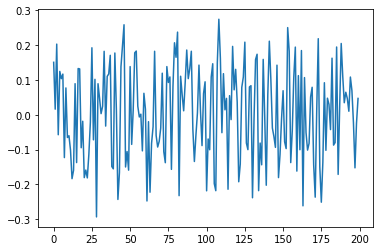

In [ ]:
plt.plot(w.T)

(array([25., 42., 17., 57., 55., 66., 45., 48., 34., 11.]),
 array([-0.1378686 , -0.00460646,  0.12865569,  0.26191783,  0.39517996,
         0.5284421 ,  0.66170424,  0.7949664 ,  0.92822856,  1.0614907 ,
         1.1947528 ], dtype=float32),
 <a list of 10 Patch objects>)

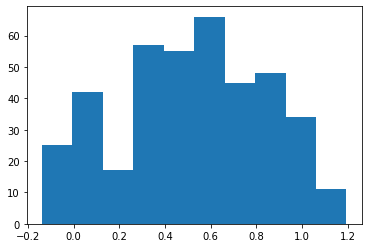

In [ ]:
plt.hist(g_slow.T)

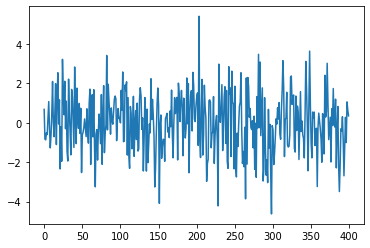

In [ ]:
plt.plot(x0)

In [ ]:
foo.shape

torch.Size([1, 400])

In [ ]:
g0 = rnn_dynamic.g0.detach().cpu().numpy()

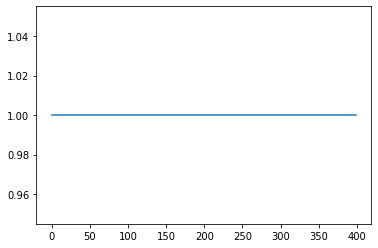

In [ ]:
plt.plot(g0.T)
plt.show()

In [ ]:
rnn_dynamic.h/6

0.8333333333333334

In [12]:
x0.shape

(400, 1)

In [18]:
bla = torch.tensor(x0.T, dtype=torch.float32).cuda()
foo = (bla.T).squeeze()
foo2 = torch.unsqueeze(foo, 1)

In [19]:
foo2.shape

torch.Size([400, 1])

In [17]:
foo.shape

torch.Size([400])